In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.stats import spearmanr

%matplotlib inline

In [89]:
def conv_dates_series(df, col, old_date_format, new_date_format):

    df[col] = pd.to_datetime(df[col], format=old_date_format).dt.strftime(new_date_format)
    
    return df

In [90]:
harvest_data = pd.read_csv("Harvest Yield March-May 2023.csv")

# Remove entries with no date
harvest_data = harvest_data[harvest_data["Date"].notna()]

# convert dates to format used by json files
new_date_format='%Y-%m-%d'
old_date_format='%m/%d/%Y'
all_data = conv_dates_series(harvest_data, "Date", old_date_format, new_date_format)

all_data.drop(["Samples kg", "BRIX", "TA", "BRIX/TA", "Causes (Grade B)", "Causes (cull)"], axis=1)

,Date,Row,Batch,Variety,Total kg,Saleable kg,Total kg (Grade B),Total kg (cull)
0,2023-03-27,28.0,"8,9",JUK,0.580,0.550,0.03,NaN
2,2023-03-27,35.0,6,JUK,2.590,2.465,0.125,NaN
3,2023-03-27,34.0,"5,6",JUK,1.290,1.290,NaN,NaN
5,2023-03-27,29.0,"7,8",JUK,3.465,3.035,0.43,NaN
7,2023-03-27,33.0,"4,5",JUK,2.280,2.020,0.26,NaN
...,...,...,...,...,...,...,...,...
510,2023-05-22,32.0,4,JUK,1.500,1.060,0.44,NaN
511,2023-05-22,19.0,10,JUK,1.680,1.530,0.15,NaN
512,2023-05-22,31.0,3,JUK,1.055,0.730,0.325,NaN
513,2023-05-22,28.0,NaN,JUK,3.940,3.840,0.1,NaN


In [94]:
# Combine instances where harvests for a single row were split into multiple entries
agg_functions = {
    "Total kg": 'sum', 
    "Total kg (Grade B)": 'sum',
    "Total kg (cull)": 'sum'
}

harvest_data = all_data.groupby(["Date", "Row"]).aggregate(agg_functions).copy()
harvest_data

Total kg Total kg (Grade B)  Total kg (cull)
Date       Row                                               
2023-03-27 5.0      1.760               0.36              0.0
           6.0      2.800               0.19              0.0
           7.0      0.615                  0              0.0
           8.0      0.385               0.21              0.0
           9.0      0.730               0.33              0.0
...                   ...                ...              ...
2023-05-22 31.0     1.055              0.325              0.0
           32.0     1.500               0.44              0.0
           33.0     1.975               0.64              0.0
           34.0     1.665              0.685              0.0
           35.0     6.285               1.65              0.0

[461 rows x 3 columns]

In [95]:
with open('harvestRuleOutput.json') as f:
    rule_data = json.load(f)
rule_data[0]

{'date': '2023-03-26',
 'overall': {'totalFruitCount': 1777,
  'scannedRowCount': 24,
  'scannedUnitCount': 1098},
 'latestHarvestDate': '2023-03-23',
 'regionName': 'All Rows (but differenter)',
 'regionSummary': '\\n         <h1>Region Summary</h1>\\n         Name: All Rows (but differenter) <br/>\\n         # of Full Rows: 72 <br/>\\n         # of Partial Rows: 0 <br/>\\n        ',
 'rows': [{'rowName': 64, 'scannedCount': 45, 'fruitCount': 267},
  {'rowName': 63, 'scannedCount': 46, 'fruitCount': 180},
  {'rowName': 58, 'scannedCount': 46, 'fruitCount': 157},
  {'rowName': 49, 'scannedCount': 46, 'fruitCount': 120},
  {'rowName': 66, 'scannedCount': 45, 'fruitCount': 116},
  {'rowName': 68, 'scannedCount': 45, 'fruitCount': 111},
  {'rowName': 67, 'scannedCount': 45, 'fruitCount': 95},
  {'rowName': 65, 'scannedCount': 45, 'fruitCount': 93},
  {'rowName': 50, 'scannedCount': 46, 'fruitCount': 87},
  {'rowName': 70, 'scannedCount': 46, 'fruitCount': 78},
  {'rowName': 69, 'scannedCo

In [96]:
for date_entry in rule_data:
    print(f"{date_entry['date']}: {len(date_entry['rows'])}")

2023-03-26: 24
2023-03-29: 46
2023-04-02: 0
2023-04-05: 0
2023-04-09: 0
2023-04-10: 0
2023-04-12: 62
2023-04-17: 8
2023-04-19: 65
2023-04-23: 71
2023-04-26: 71
2023-04-30: 71
2023-05-03: 71
2023-05-07: 71
2023-05-10: 71
2023-05-14: 61
2023-05-17: 71


In [97]:
# Parse json data entry into 2d array, combining counts for fruit in the same gutter
def parse_rule_data(data):
    entries = []
    for date_entry in data:
        # add one day to date to match harvest data, since monitoring was done the day before
        date = (pd.to_datetime(date_entry["date"]) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        counts = {}
        for row in date_entry['rows']:
            rowNum = np.ceil(row['rowName']/2)
            if rowNum in counts:
                counts[rowNum] += row['fruitCount']
            else: 
                counts[rowNum] = row['fruitCount']
        for rowNum in counts:
            entries.append([date, rowNum, counts[rowNum]])
    return pd.DataFrame(entries, columns=["Date", "Row", "Monitoring Count"])

In [98]:
rule_df = parse_rule_data(rule_data)

In [99]:
df = pd.merge(harvest_data, rule_df, on=['Date', 'Row'], how='outer')
df

,Date,Row,Total kg,Total kg (Grade B),Total kg (cull),Monitoring Count
0,2023-03-27,5.0,1.760,0.36,0.0,NaN
1,2023-03-27,6.0,2.800,0.19,0.0,NaN
2,2023-03-27,7.0,0.615,0,0.0,NaN
3,2023-03-27,8.0,0.385,0.21,0.0,NaN
4,2023-03-27,9.0,0.730,0.33,0.0,NaN
...,...,...,...,...,...,...
544,2023-05-18,8.0,NaN,NaN,NaN,159.0
545,2023-05-18,17.0,NaN,NaN,NaN,130.0
546,2023-05-18,36.0,NaN,NaN,NaN,0.0
547,2023-05-18,15.0,NaN,NaN,NaN,0.0


In [100]:
# Confirm that no harvesting was ever done on a monitoring row that reported zero fruits
df.loc[(df["Monitoring Count"] == 0) & df["Total kg"].notna()]

,Date,Row,Total kg,Total kg (Grade B),Total kg (cull),Monitoring Count


In [101]:
# Filter down to the data where a nonzero monitoring count was reported
monitored_df = df[
    df["Monitoring Count"].notna() &
    df["Total kg"].notna() &
    (pd.to_datetime(df["Date"]) > pd.to_datetime("2023-04-10")) &
    (df["Monitoring Count"] != 0)].copy()

In [102]:
# Add a row calculating the ratio of count/kg
values = monitored_df["Monitoring Count"]/monitored_df["Total kg"]
monitored_df["Count/Kg"] = values

In [103]:
monitored_df

,Date,Row,Total kg,Total kg (Grade B),Total kg (cull),Monitoring Count,Count/Kg
132,2023-04-13,5.0,0.415,0.14,0.0,75.0,180.722892
133,2023-04-13,6.0,0.547,0.17,0.0,228.0,416.819013
134,2023-04-13,7.0,0.840,0.255,0.0,108.0,128.571429
135,2023-04-13,8.0,0.865,0.22,0.0,116.0,134.104046
136,2023-04-13,10.0,0.650,0.105,0.0,86.0,132.307692
...,...,...,...,...,...,...,...
432,2023-05-18,30.0,0.900,0.38,0.0,58.0,64.444444
433,2023-05-18,31.0,0.960,0.365,0.0,103.0,107.291667
434,2023-05-18,32.0,0.845,0.25,0.0,91.0,107.692308
435,2023-05-18,33.0,1.300,0.17,0.0,100.0,76.923077


Text(0, 0.5, 'Frequency')

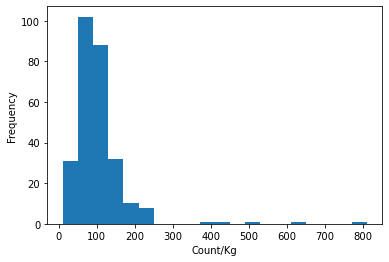

In [104]:
plt.hist(monitored_df["Count/Kg"], bins=20);
plt.xlabel("Count/Kg")
plt.ylabel("Frequency")

In [105]:
print(np.mean(monitored_df["Count/Kg"]))
print(np.std(monitored_df["Count/Kg"]))

105.56538891189413
78.05641434221899


In [125]:
truncated_ratios = monitored_df[monitored_df["Count/Kg"] < 300]["Count/Kg"]

Text(0, 0.5, 'Frequency')

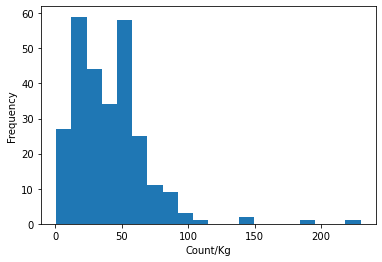

In [126]:
plt.hist(truncated_ratios, bins = 20);
plt.xlabel("Count/Kg")
plt.ylabel("Frequency")

In [127]:
np.mean(truncated_ratios)

40.57296876289367

In [128]:
np.std(truncated_ratios)

27.8403943816211

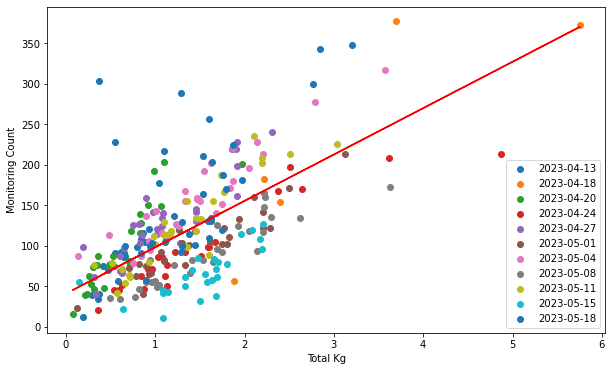

In [110]:
x = monitored_df["Total kg"]
y = monitored_df["Monitoring Count"]
m, b = np.polyfit(x, y, 1)
plt.figure(figsize=(10,6))

plt.plot(x, m*x + b, color='red')

for date in sorted(set(monitored_df["Date"])):
    subsample = monitored_df[monitored_df["Date"] == date]
    x_sub = subsample["Total kg"]
    y_sub = subsample["Monitoring Count"]
    plt.scatter(x_sub, y_sub, label=date)

plt.xlabel("Total Kg")
plt.ylabel("Monitoring Count")
plt.legend()

In [111]:
corr_matrix = np.corrcoef(x, y)
corr = corr_matrix[0,1]
R_sq = corr**2
R_sq

0.4653389669832408

## Rank Results

In [112]:
monitored_df["harvest_weight_rank"] = monitored_df.groupby("Date")["Total kg"].rank(method="dense", ascending=False)
monitored_df["monitoring_count_rank"] = monitored_df.groupby("Date")["Monitoring Count"].rank(method="dense", ascending=False)
monitored_df

,Date,Row,Total kg,Total kg (Grade B),Total kg (cull),Monitoring Count,Count/Kg,harvest_weight_rank,monitoring_count_rank
132,2023-04-13,5.0,0.415,0.14,0.0,75.0,180.722892,20.0,18.0
133,2023-04-13,6.0,0.547,0.17,0.0,228.0,416.819013,18.0,5.0
134,2023-04-13,7.0,0.840,0.255,0.0,108.0,128.571429,10.0,11.0
135,2023-04-13,8.0,0.865,0.22,0.0,116.0,134.104046,9.0,10.0
136,2023-04-13,10.0,0.650,0.105,0.0,86.0,132.307692,13.0,17.0
...,...,...,...,...,...,...,...,...,...
432,2023-05-18,30.0,0.900,0.38,0.0,58.0,64.444444,23.0,23.0
433,2023-05-18,31.0,0.960,0.365,0.0,103.0,107.291667,21.0,18.0
434,2023-05-18,32.0,0.845,0.25,0.0,91.0,107.692308,24.0,22.0
435,2023-05-18,33.0,1.300,0.17,0.0,100.0,76.923077,15.0,20.0


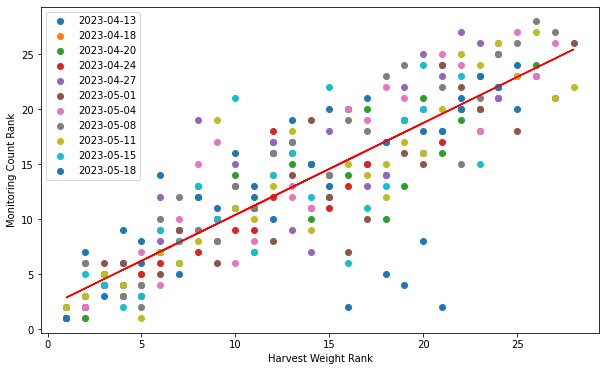

In [113]:
x = monitored_df["harvest_weight_rank"]
y = monitored_df["monitoring_count_rank"]
m, b = np.polyfit(x, y, 1)
plt.figure(figsize=(10,6))

plt.plot(x, m*x + b, color='red')

for date in sorted(set(monitored_df["Date"])):
    subsample = monitored_df[monitored_df["Date"] == date]
    x_sub = subsample["harvest_weight_rank"]
    y_sub = subsample["monitoring_count_rank"]
    plt.scatter(x_sub, y_sub, label=date)

plt.xlabel("Harvest Weight Rank")
plt.ylabel("Monitoring Count Rank")
plt.legend()

In [114]:
rho, p = spearmanr(x, y)
print(f"Spearman Rank Correlation: {rho}")
print(f"p-value: {p}")

Spearman Rank Correlation: 0.8620302337955813
p-value: 7.67686094568388e-83


In [115]:
monitored_df[monitored_df["Date"] == "2023-04-13"]["Row"]

132     5.0
133     6.0
134     7.0
135     8.0
136    10.0
137    11.0
138    12.0
139    13.0
140    14.0
141    20.0
142    21.0
143    22.0
144    23.0
145    24.0
146    25.0
147    26.0
148    27.0
149    28.0
150    29.0
151    30.0
152    31.0
153    32.0
154    33.0
155    34.0
156    35.0
Name: Row, dtype: float64

## Red Fruit Only

Note that I'm lazy and this will overwrite some of the data above

In [116]:
with open('harvestRuleOutputRedOnly.json') as f:
    red_data = json.load(f)

red_df = parse_rule_data(red_data)

In [117]:
df = pd.merge(harvest_data, red_df, on=['Date', 'Row'], how='outer')
df

,Date,Row,Total kg,Total kg (Grade B),Total kg (cull),Monitoring Count
0,2023-03-27,5.0,1.760,0.36,0.0,NaN
1,2023-03-27,6.0,2.800,0.19,0.0,NaN
2,2023-03-27,7.0,0.615,0,0.0,NaN
3,2023-03-27,8.0,0.385,0.21,0.0,NaN
4,2023-03-27,9.0,0.730,0.33,0.0,NaN
...,...,...,...,...,...,...
544,2023-05-18,8.0,NaN,NaN,NaN,58.0
545,2023-05-18,17.0,NaN,NaN,NaN,44.0
546,2023-05-18,36.0,NaN,NaN,NaN,0.0
547,2023-05-18,15.0,NaN,NaN,NaN,0.0


In [118]:
monitored_df = df[
    df["Monitoring Count"].notna() &
    df["Total kg"].notna() &
    (pd.to_datetime(df["Date"]) > pd.to_datetime("2023-04-10")) &
    (df["Monitoring Count"] != 0)].copy()

values = monitored_df["Monitoring Count"]/monitored_df["Total kg"]
monitored_df["Count/Kg"] = values

monitored_df

,Date,Row,Total kg,Total kg (Grade B),Total kg (cull),Monitoring Count,Count/Kg
132,2023-04-13,5.0,0.415,0.14,0.0,15.0,36.144578
133,2023-04-13,6.0,0.547,0.17,0.0,101.0,184.643510
134,2023-04-13,7.0,0.840,0.255,0.0,36.0,42.857143
135,2023-04-13,8.0,0.865,0.22,0.0,45.0,52.023121
136,2023-04-13,10.0,0.650,0.105,0.0,38.0,58.461538
...,...,...,...,...,...,...,...
432,2023-05-18,30.0,0.900,0.38,0.0,27.0,30.000000
433,2023-05-18,31.0,0.960,0.365,0.0,45.0,46.875000
434,2023-05-18,32.0,0.845,0.25,0.0,42.0,49.704142
435,2023-05-18,33.0,1.300,0.17,0.0,53.0,40.769231


Text(0, 0.5, 'Frequency')

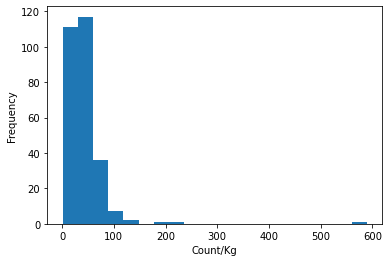

In [119]:
plt.hist(monitored_df["Count/Kg"], bins=20);
plt.xlabel("Count/Kg")
plt.ylabel("Frequency")

In [120]:
print(np.mean(monitored_df["Count/Kg"]))
print(np.std(monitored_df["Count/Kg"]))

42.5612309533663
43.12082523599339


Text(0, 0.5, 'Frequency')

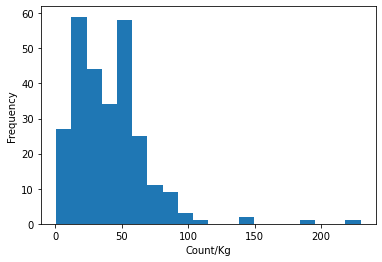

In [121]:
truncated_ratios = monitored_df[monitored_df["Count/Kg"] < 400]["Count/Kg"]
plt.hist(truncated_ratios, bins = 20);
plt.xlabel("Count/Kg")
plt.ylabel("Frequency")

In [122]:
print(np.mean(truncated_ratios))
print(np.std(truncated_ratios))

40.57296876289367
27.8403943816211


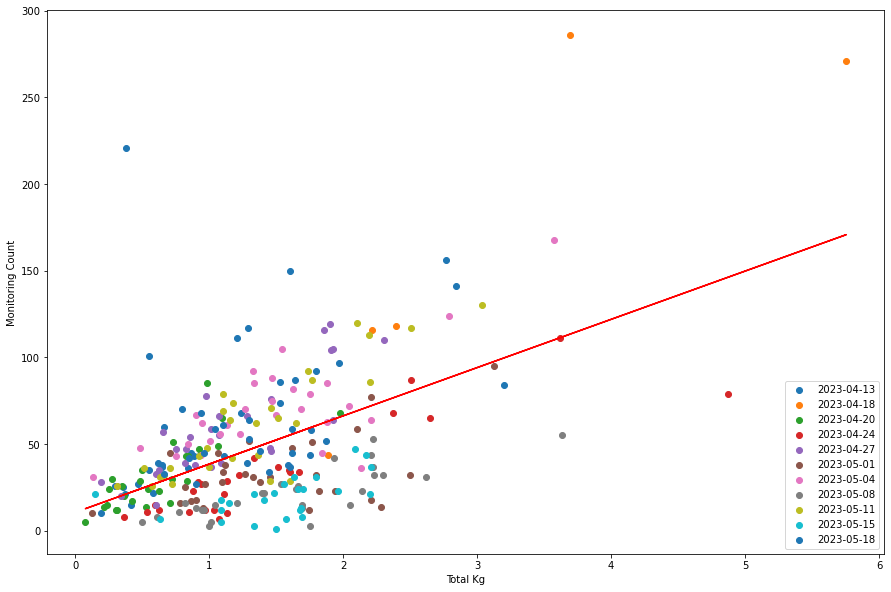

In [123]:
x = monitored_df["Total kg"]
y = monitored_df["Monitoring Count"]
m, b = np.polyfit(x, y, 1)
plt.figure(figsize=(15,10))

plt.plot(x, m*x + b, color='red')

for date in sorted(set(monitored_df["Date"])):
    subsample = monitored_df[monitored_df["Date"] == date]
    x_sub = subsample["Total kg"]
    y_sub = subsample["Monitoring Count"]
    plt.scatter(x_sub, y_sub, label=date)

plt.xlabel("Total Kg")
plt.ylabel("Monitoring Count")
plt.legend();

In [124]:
corr_matrix = np.corrcoef(x, y)
corr = corr_matrix[0,1]
R_sq = corr**2
R_sq

0.3089988425288503